In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [4]:
# Read the CSV file into a DataFrame
df = pd.read_csv('./match_data_v5.csv')
df.columns = ["matchId", "blueTeamControlWardsPlaced", "blueTeamWardsPlaced", "blueTeamTotalKills",
              "blueTeamDragonKills", "blueTeamHeraldKills", "blueTeamTowersDestroyed",
              "blueTeamInhibitorsDestroyed", "blueTeamTurretPlatesDestroyed", "blueTeamFirstBlood",
              "blueTeamMinionsKilled", "blueTeamJungleMinions", "blueTeamTotalGold",
              "blueTeamXp", "blueTeamTotalDamageToChamps", "redTeamControlWardsPlaced",
              "redTeamWardsPlaced", "redTeamTotalKills", "redTeamDragonKills", "redTeamHeraldKills",
              "redTeamTowersDestroyed", "redTeamInhibitorsDestroyed", "redTeamTurretPlatesDestroyed",
              "redTeamMinionsKilled", "redTeamJungleMinions", "redTeamTotalGold", "redTeamXp",
              "redTeamTotalDamageToChamps", "blueWin"]
# Drop unused columns and transform variable types
df = df.drop(columns=['matchId'])
df['blueTeamFirstBlood'] = df['blueTeamFirstBlood'].astype('category')
df['blueWin'] = df['blueWin'].astype('category')

,blueTeamControlWardsPlaced,blueTeamWardsPlaced,blueTeamTotalKills,blueTeamDragonKills,blueTeamHeraldKills,blueTeamTowersDestroyed,blueTeamInhibitorsDestroyed,blueTeamTurretPlatesDestroyed,blueTeamFirstBlood,blueTeamMinionsKilled,...,redTeamHeraldKills,redTeamTowersDestroyed,redTeamInhibitorsDestroyed,redTeamTurretPlatesDestroyed,redTeamMinionsKilled,redTeamJungleMinions,redTeamTotalGold,redTeamXp,redTeamTotalDamageToChamps,blueWin
0,2,46,12,1,0,1,0,10,0,348,...,0,1,0,4,373,76,28970,30320,36585,0
1,2,19,13,0,0,0,0,11,0,331,...,0,2,0,3,340,84,30510,29464,42984,0
2,3,28,8,0,1,1,0,9,1,355,...,0,0,0,5,378,87,25157,31069,28229,0
3,3,30,11,1,1,1,0,7,0,370,...,0,1,0,5,382,96,26052,29475,19245,1
4,2,24,3,0,0,0,0,16,0,369,...,1,3,0,3,357,70,28368,30422,30967,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24219,0,27,1,1,0,0,0,5,0,282,...,0,0,0,0,370,102,26134,30760,22845,0
24220,4,29,5,0,0,0,0,4,0,323,...,0,1,0,2,365,80,25169,30857,29694,0
24221,1,25,16,1,1,1,0,11,0,300,...,0,1,0,4,342,81,30528,29566,36545,0
24222,4,27,15,0,0,1,0,9,0,364,...,0,2,0,2,341,74,31761,30573,42858,0


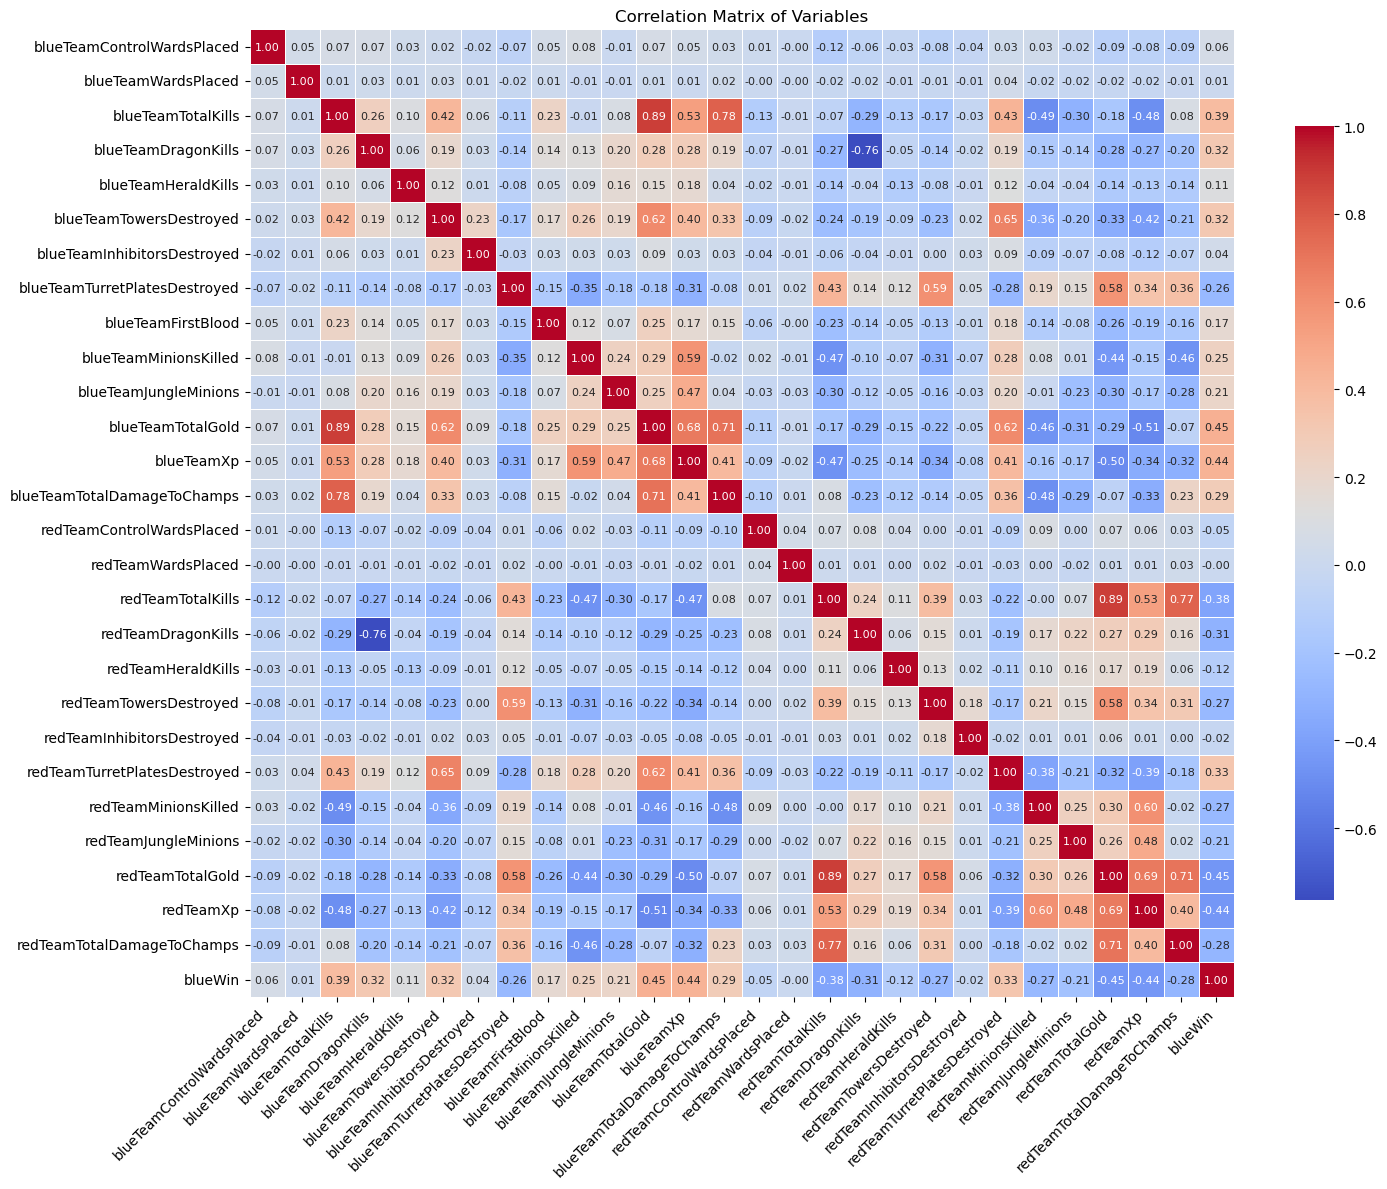

In [225]:
# Create the correlation heatmap
plt.figure(figsize=(15, 12))  # Adjust the size to fit the plot
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f',
            linewidths=0.5, cbar_kws={'shrink': 0.8}, annot_kws={'size': 8})

# Add titles and labels
plt.title('Correlation Matrix of Variables')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels to prevent overlap
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.tight_layout()  # Adjust layout to fit everything

# Show the plot
plt.show()

In [226]:
# Variable creation for variables that have high correlation
# dragDiff
df['dragDiff'] = df['blueTeamDragonKills'] - df['redTeamDragonKills']
df = df.drop(columns=['blueTeamDragonKills', 'redTeamDragonKills'])

# goldDiff
df['goldDiff'] = df['blueTeamTotalGold'] - df['redTeamTotalGold']
df = df.drop(columns=['blueTeamTotalGold', 'redTeamTotalGold'])

# xpDiff
df['xpDiff'] = df['blueTeamXp'] - df['redTeamXp']
df = df.drop(columns=['blueTeamXp', 'redTeamXp'])

# killDiff
df['killDiff'] = df['blueTeamTotalKills'] - df['redTeamTotalKills']
df = df.drop(columns=['blueTeamTotalKills', 'redTeamTotalKills'])

#towerDiff
df['towerDiff'] = df['blueTeamTowersDestroyed'] - df['redTeamTowersDestroyed']
df = df.drop(columns=['blueTeamTowersDestroyed', 'redTeamTowersDestroyed'])

#plateDiff
df['plateDiff'] = df['blueTeamTurretPlatesDestroyed'] - df['redTeamTurretPlatesDestroyed']
df = df.drop(columns=['blueTeamTurretPlatesDestroyed', 'redTeamTurretPlatesDestroyed'])

#inhibDiff
df['inhibDiff'] = df['blueTeamInhibitorsDestroyed'] - df['redTeamInhibitorsDestroyed']
df = df.drop(columns=['blueTeamInhibitorsDestroyed', 'redTeamInhibitorsDestroyed'])

#minionDiff
df['minionDiff'] = df['blueTeamMinionsKilled'] - df['redTeamMinionsKilled']
df = df.drop(columns=['blueTeamMinionsKilled', 'redTeamMinionsKilled'])

#jgMinionDiff
df['jgMinionDiff'] = df['blueTeamJungleMinions'] - df['redTeamJungleMinions']
df = df.drop(columns=['blueTeamJungleMinions', 'redTeamJungleMinions'])

#damageDiff
df['damageDiff'] = df['blueTeamTotalDamageToChamps'] - df['redTeamTotalDamageToChamps']
df = df.drop(columns=['blueTeamTotalDamageToChamps', 'redTeamTotalDamageToChamps'])

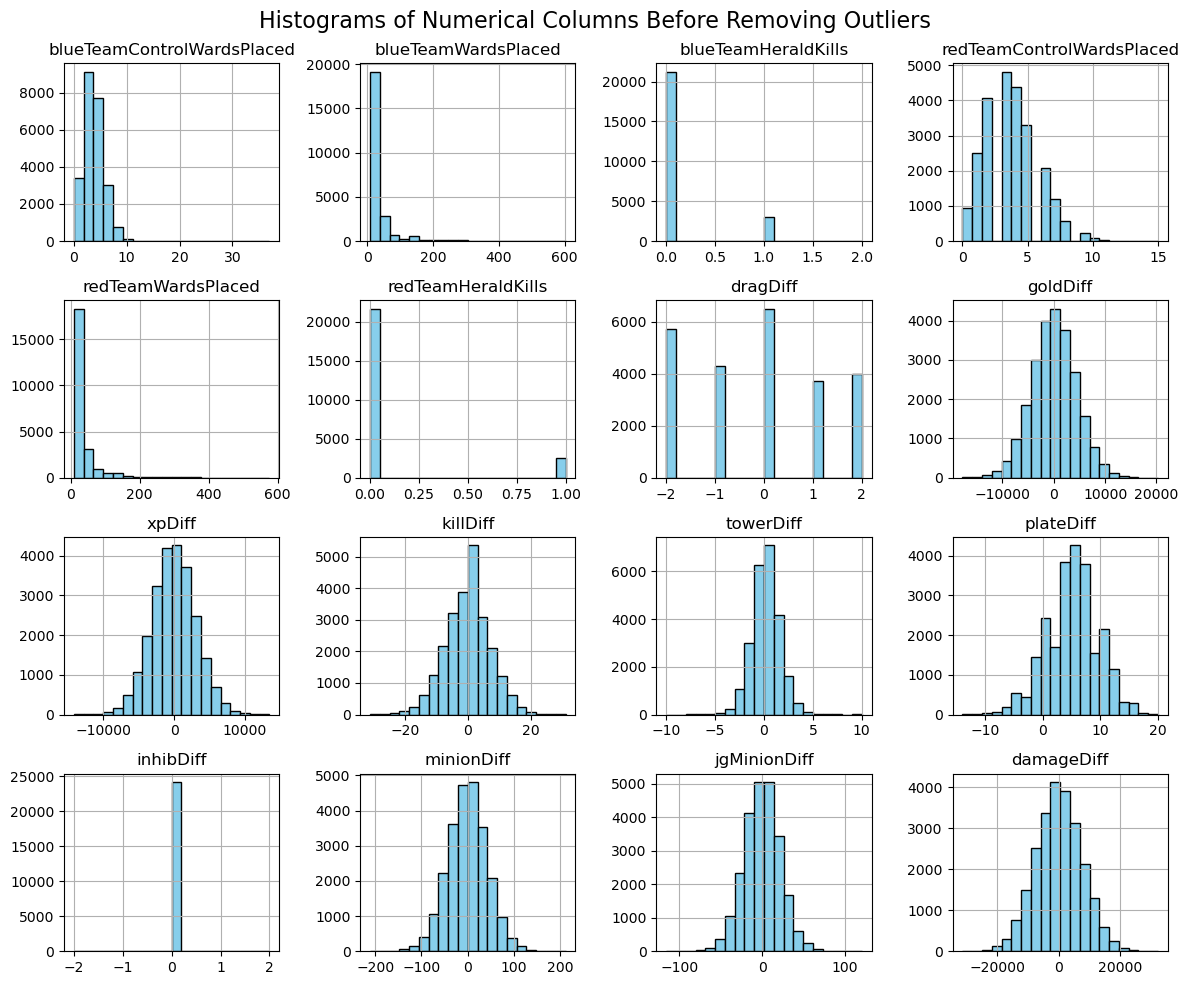

In [227]:
# Create histograms for all numerical columns (pre-outlier deletion)
df.select_dtypes(include=['float64', 'int64']).hist(bins=20, figsize=(12, 10), color='skyblue', edgecolor='black')

# Add a title
plt.suptitle('Histograms of Numerical Columns Before Removing Outliers', fontsize=16)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [228]:
# Remove outliers that win even having a huge gold deficit/lost even having a large gold deficit
df = df[~(((df['goldDiff'] >= 4000) & (df['blueWin'] == 0)) | ((df['goldDiff'] <= -4000) & (df['blueWin'] == 1)))]
df

,blueTeamControlWardsPlaced,blueTeamWardsPlaced,blueTeamHeraldKills,blueTeamFirstBlood,redTeamControlWardsPlaced,redTeamWardsPlaced,redTeamHeraldKills,blueWin,dragDiff,goldDiff,xpDiff,killDiff,towerDiff,plateDiff,inhibDiff,minionDiff,jgMinionDiff,damageDiff
0,2,46,0,0,6,26,0,0,1,-1118,210,-5,0,6,0,-25,22,-768
1,2,19,0,0,3,241,0,0,-1,-2384,37,-5,-2,8,0,-9,12,-4945
2,3,28,1,1,0,23,0,0,-1,2176,-603,-2,1,4,0,-23,-3,3109
3,3,30,1,0,7,26,0,1,0,1720,1591,4,0,2,0,-12,4,7431
4,2,24,0,0,1,33,1,0,-2,-4357,-3550,-12,-3,13,0,12,10,-8553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24219,0,27,0,0,6,37,0,0,0,-5764,-6537,-9,0,5,0,-88,4,-3442
24220,4,29,0,0,2,25,0,0,-1,-1831,-2146,-4,-1,2,0,-42,16,-6230
24221,1,25,1,0,5,31,0,0,0,-2663,-1020,-2,0,7,0,-42,13,-5752
24222,4,27,0,0,1,40,0,0,-2,-4526,-1811,-8,-1,7,0,23,-14,-8954


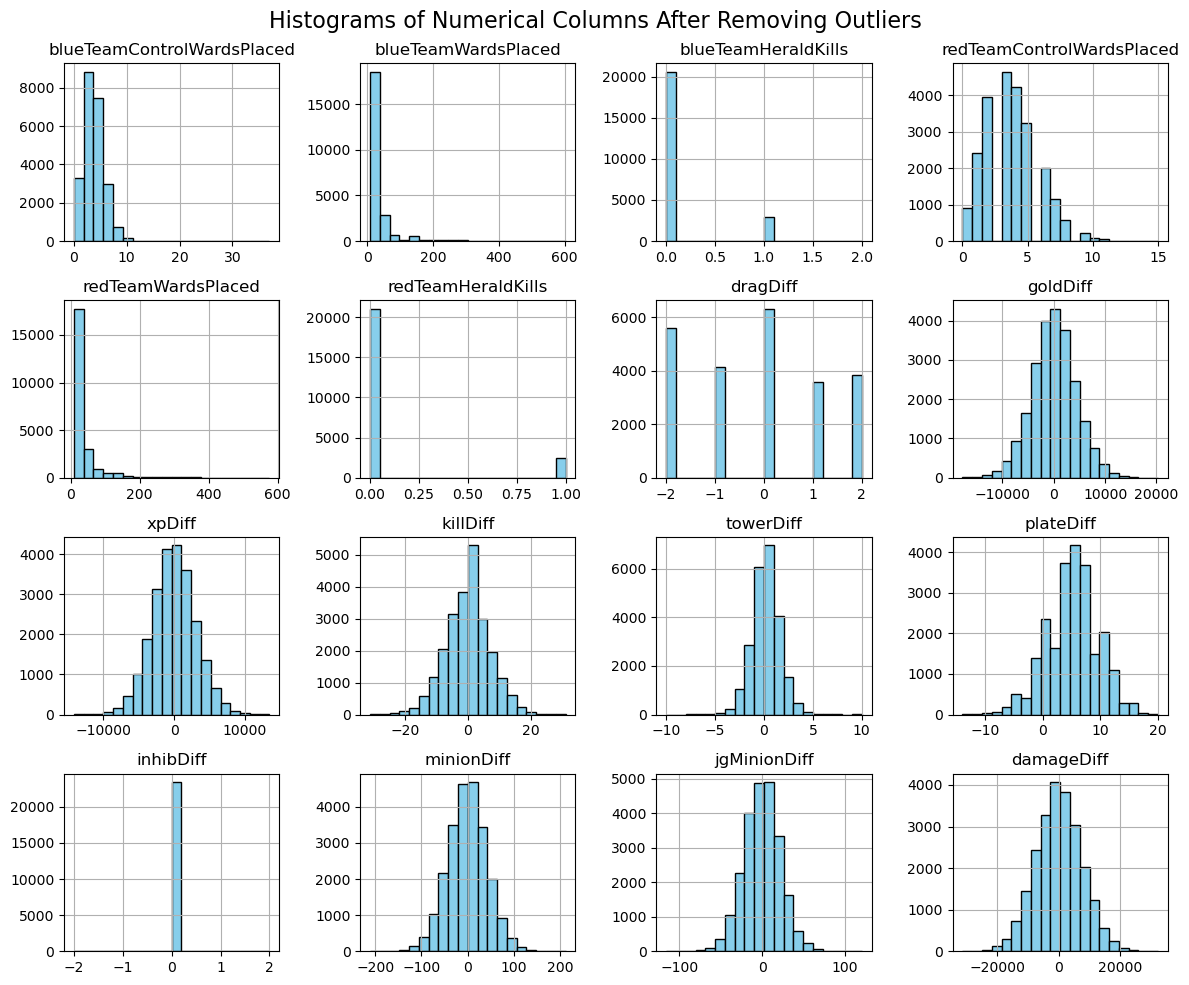

In [229]:
# Create histograms for all numerical columns (post-outlier deletion)
df.select_dtypes(include=['float64', 'int64']).hist(bins=20, figsize=(12, 10), color='skyblue', edgecolor='black')

# Add a title
plt.suptitle('Histograms of Numerical Columns After Removing Outliers', fontsize=16)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [251]:
# Create target columns for prediction and determine value of K
X = df.drop(columns=['blueWin'])
y = df['blueWin']
k = 5

results = {
    'Model': [],
    'Accuracy': [],
    'Accuracy SD': [],
    'Precision': [],
    'Precision SD': [],
    'Recall': [],
    'Recall SD': [],
    'F1-Score': [],
    'F1-Score SD': [],
}

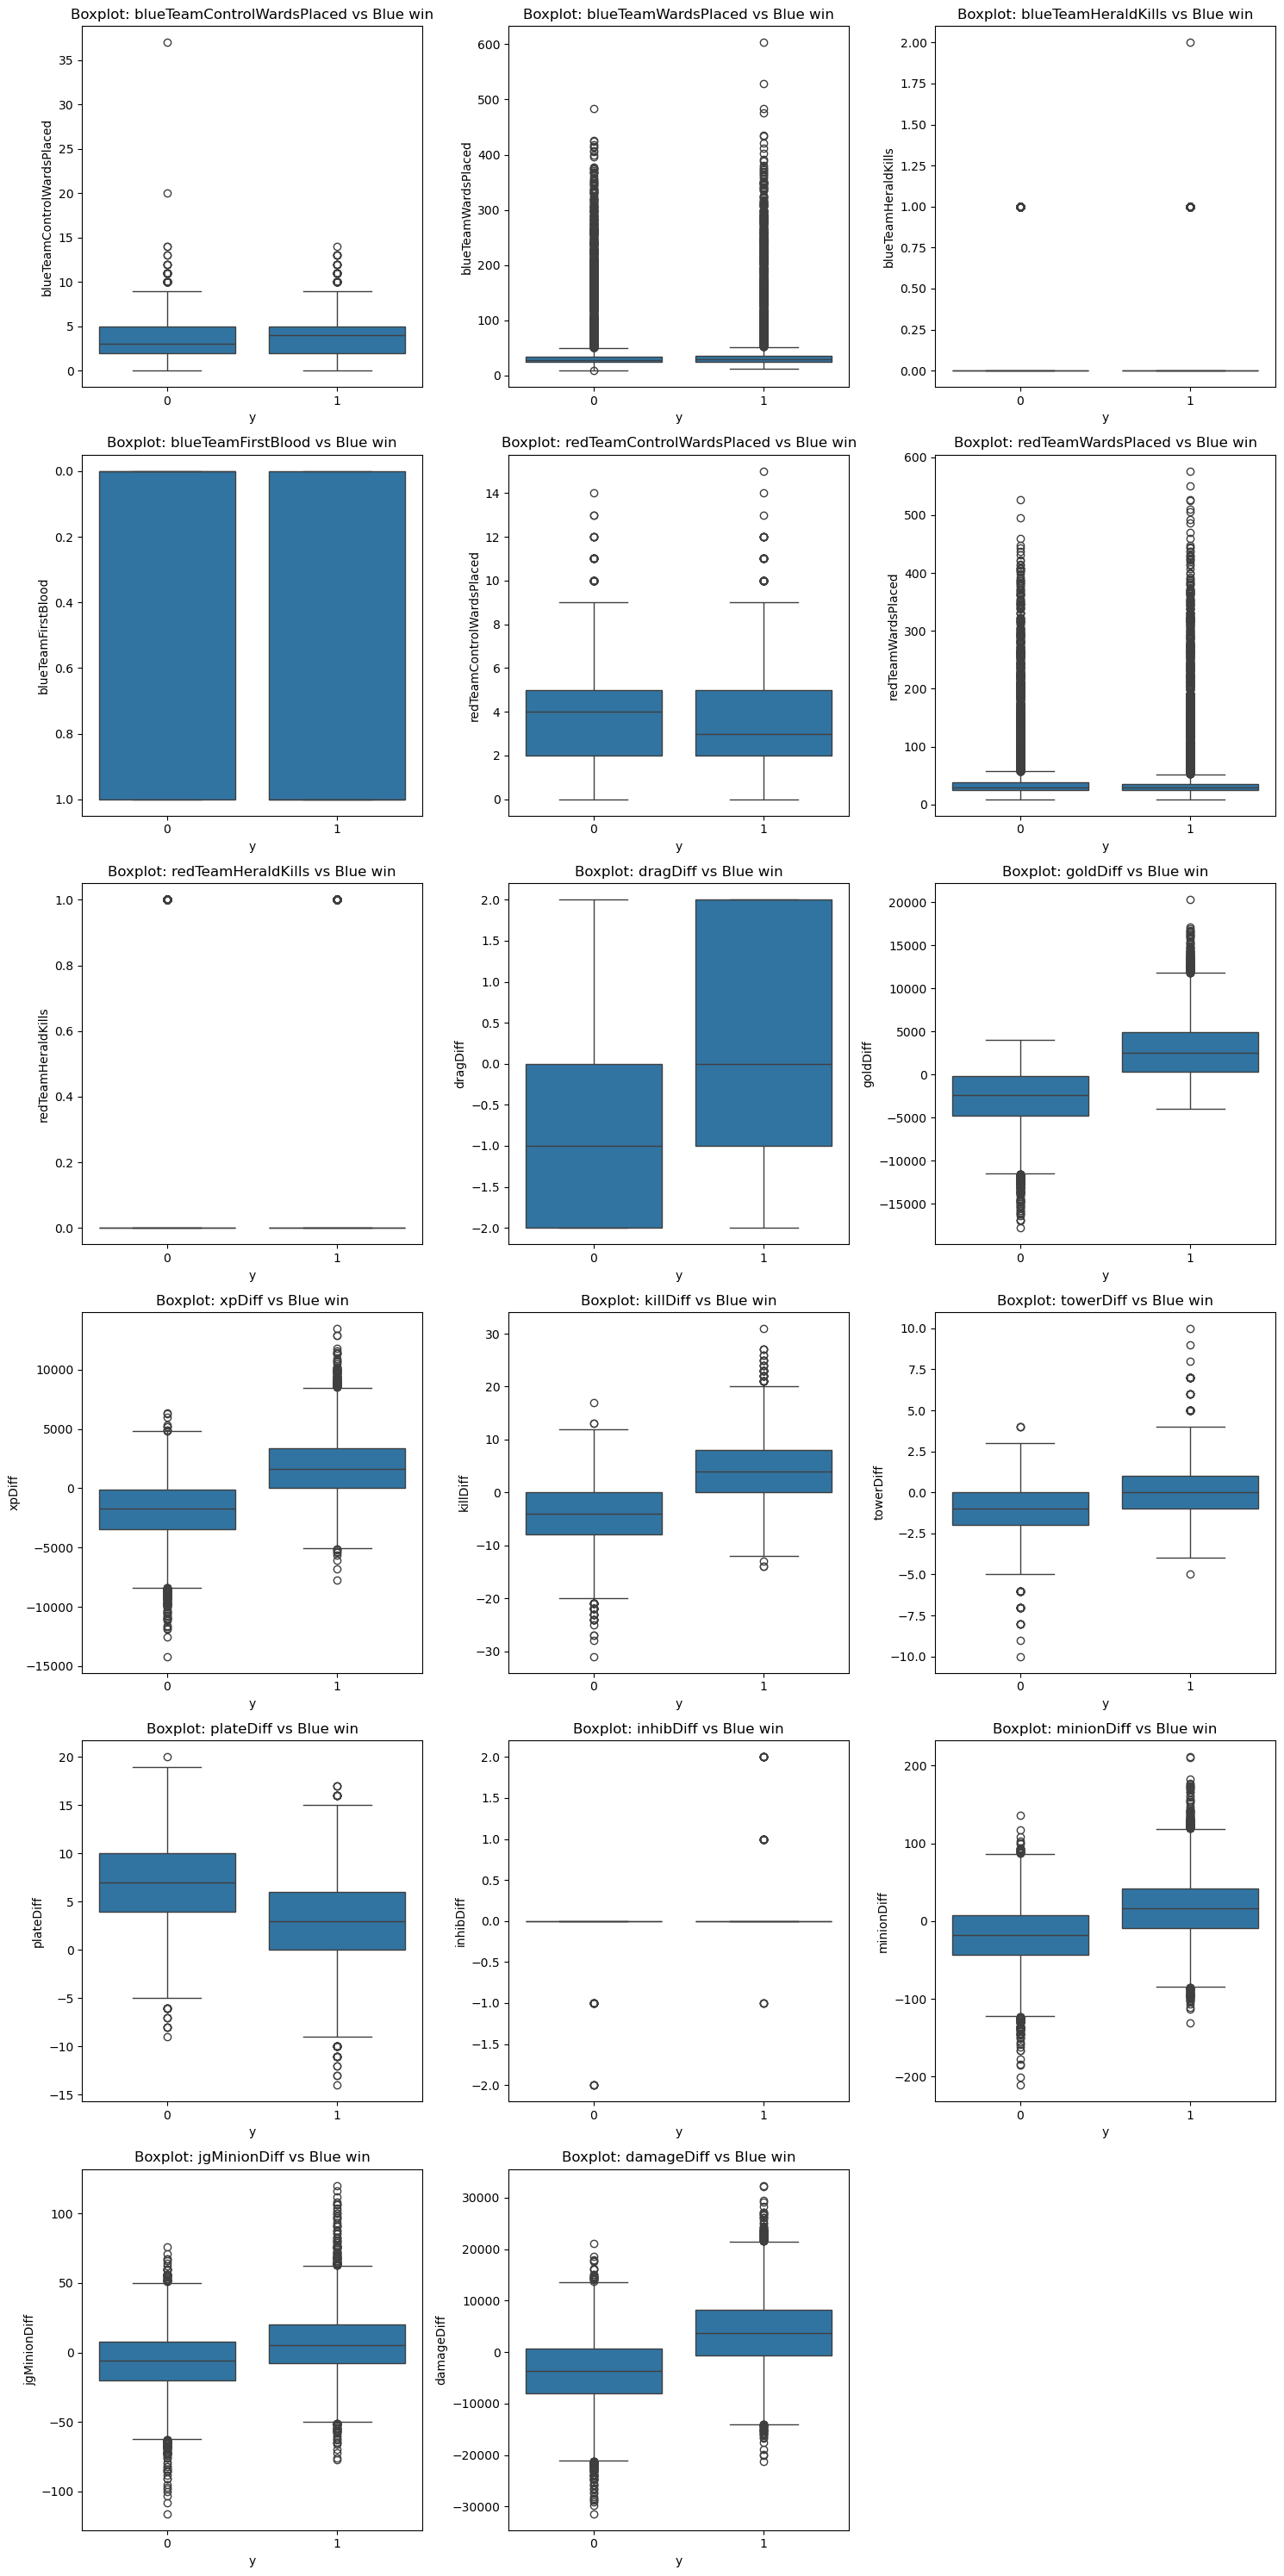

In [231]:
# Boxplots of features

# Calculate the number of rows and columns for the grid
n_cols = 3  # Adjust the number of columns as needed
n_rows = int(np.ceil(X.shape[1] / n_cols))  # Ensure enough rows to fit all features

# Create a figure with a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop through each feature and create a boxplot
for i, column in enumerate(X.columns):
    sns.boxplot(x=y, y=X[column], ax=axes[i])
    axes[i].set_title(f'Boxplot: {column} vs Blue win')
    axes[i].set_xlabel('y')
    axes[i].set_ylabel(column)

# Remove empty subplots if the grid is larger than needed
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

Selected features: Index(['blueTeamControlWardsPlaced', 'blueTeamWardsPlaced',
       'blueTeamHeraldKills', 'blueTeamFirstBlood',
       'redTeamControlWardsPlaced', 'redTeamWardsPlaced', 'redTeamHeraldKills',
       'dragDiff', 'goldDiff', 'xpDiff', 'killDiff', 'towerDiff', 'plateDiff',
       'minionDiff', 'jgMinionDiff', 'damageDiff'],
      dtype='object')
Selected features: Index(['blueTeamControlWardsPlaced', 'blueTeamWardsPlaced',
       'blueTeamHeraldKills', 'blueTeamFirstBlood',
       'redTeamControlWardsPlaced', 'redTeamWardsPlaced', 'redTeamHeraldKills',
       'dragDiff', 'goldDiff', 'xpDiff', 'killDiff', 'towerDiff', 'plateDiff',
       'minionDiff', 'jgMinionDiff', 'damageDiff'],
      dtype='object')
Selected features: Index(['blueTeamControlWardsPlaced', 'blueTeamWardsPlaced',
       'blueTeamHeraldKills', 'blueTeamFirstBlood',
       'redTeamControlWardsPlaced', 'redTeamWardsPlaced', 'redTeamHeraldKills',
       'dragDiff', 'goldDiff', 'xpDiff', 'killDiff', 'towerDi

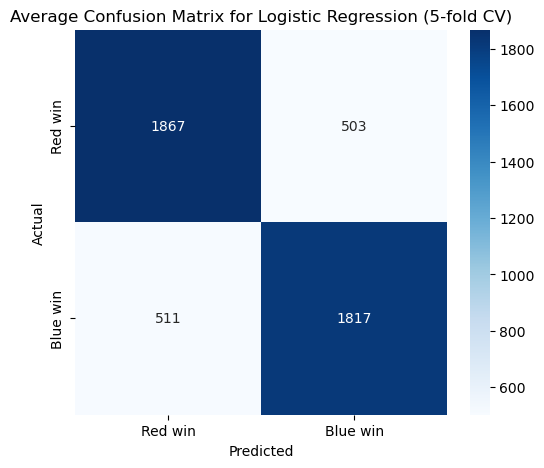

In [252]:
# Fit on Logistic Regression with k-fold CV

# Initialize hyperparameters and models
kf = KFold(n_splits=k, shuffle=True, random_state=42)
logreg = LogisticRegression(solver='liblinear', penalty='l1', random_state=42)
accuracies = []
precisions = []
recalls = []
f1s = []
confusion_matrices = []

# Loop through each fold
for train_index, test_index in kf.split(X):  # Assuming X is the feature matrix
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Predict the probabilities of the test set
    logreg.fit(X_train, y_train)

    # Convert probabilities to binary predictions (threshold = 0.5)
    y_pred = logreg.predict(X_test)

    # Output selected features
    selected_column_names = X.columns[np.where(logreg.coef_[0] != 0)[0]]
    print(f"Selected features: {selected_column_names}")

    # Calculate metrics for this fold and append it to metric list
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    # Compute confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

# Calculate average accuracy across all folds
print(f"Average Accuracy across {k}-folds: {np.mean(accuracies):.4f}")

# Store all average metrics in final table
results['Model'].append("Logistic Regression")
results['Accuracy'].append(np.mean(accuracies))
results['Accuracy SD'].append(np.std(accuracies))
results['Precision'].append(np.mean(precisions))
results['Precision SD'].append(np.std(precisions))
results['Recall'].append(np.mean(recalls))
results['Recall SD'].append(np.std(recalls))
results['F1-Score'].append(np.mean(f1s))
results['F1-Score SD'].append(np.std(f1s))
# Calculate the average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0).astype(int)

# Plot Confusion Matrix as Heatmap (average confusion matrix)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Red win', 'Blue win'], yticklabels=['Red win', 'Blue win'])
plt.title(f"Average Confusion Matrix for Logistic Regression ({k}-fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [244]:
# Drop inhibDiff column that is removed by the l1 penalty in logistic regression
X = X.drop(columns=['inhibDiff'])

Average Accuracy across 5-folds: 0.7841


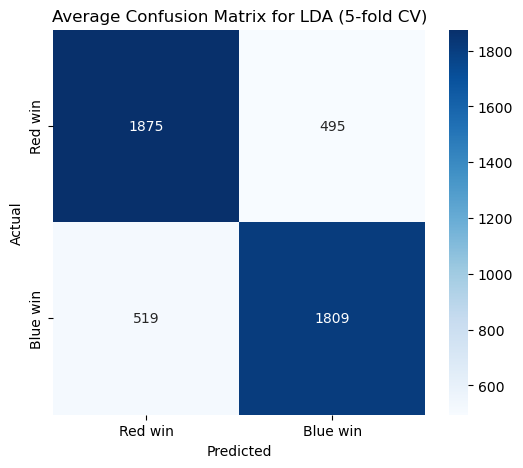

In [253]:
# Fit on LDA with k-fold CV
# Initialize hyperparameters and models
kf = KFold(n_splits=k, shuffle=True, random_state=42)
lda = LinearDiscriminantAnalysis()

# Initialize variables to store results
accuracies = []
precisions = []
recalls = []
f1s = []
confusion_matrices = []

# Loop through each fold
for train_index, test_index in kf.split(X):  # Assuming X is the feature matrix
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    lda.fit(X_train, y_train)

    # Predict the labels
    y_pred = lda.predict(X_test)

    # Calculate metrics for this fold and append it to metric list
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    # Compute confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

# Calculate average accuracy across all folds
print(f"Average Accuracy across {k}-folds: {np.mean(accuracies):.4f}")

# Store all average metrics in final table
results['Model'].append("LDA")
results['Accuracy'].append(np.mean(accuracies))
results['Accuracy SD'].append(np.std(accuracies))
results['Precision'].append(np.mean(precisions))
results['Precision SD'].append(np.std(precisions))
results['Recall'].append(np.mean(recalls))
results['Recall SD'].append(np.std(recalls))
results['F1-Score'].append(np.mean(f1s))
results['F1-Score SD'].append(np.std(f1s))

# Calculate the average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0).astype(int)

# Plot acerage Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Red win', 'Blue win'], yticklabels=['Red win', 'Blue win'])
plt.title(f"Average Confusion Matrix for LDA ({k}-fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Average Accuracy across 5-folds: 0.7766


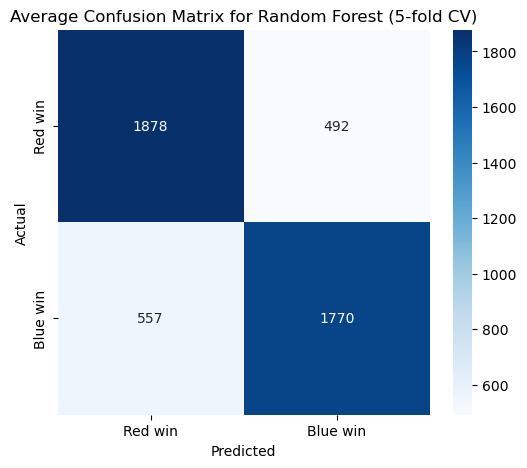

In [254]:
# Fit on Random Forest with k-fold CV
# Initialize hyperparameters and models
kf = KFold(n_splits=k, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)

# Initialize variables to store results
accuracies = []
precisions = []
recalls = []
f1s = []
confusion_matrices = []

# Loop through each fold
for train_index, test_index in kf.split(X):  # Assuming X is the feature matrix
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    rf_model.fit(X_train, y_train)

    # Predict the labels
    y_pred = rf_model.predict(X_test)

    # Calculate metrics for this fold and append it to metric list
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    # Compute confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

# Calculate average accuracy across all folds
print(f"Average Accuracy across {k}-folds: {np.mean(accuracies):.4f}")

# Store all average metrics in final table
results['Model'].append("Random Forest")
results['Accuracy'].append(np.mean(accuracies))
results['Accuracy SD'].append(np.std(accuracies))
results['Precision'].append(np.mean(precisions))
results['Precision SD'].append(np.std(precisions))
results['Recall'].append(np.mean(recalls))
results['Recall SD'].append(np.std(recalls))
results['F1-Score'].append(np.mean(f1s))
results['F1-Score SD'].append(np.std(f1s))

# Calculate the average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0).astype(int)

# Plot acerage Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Red win', 'Blue win'], yticklabels=['Red win', 'Blue win'])
plt.title(f"Average Confusion Matrix for Random Forest ({k}-fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [221]:
# Search for best hyperparameters for XGB with Bayesian Optimization
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), eval_metric="auc", enable_categorical=True,
            early_stopping_rounds=10)

    evaluation = [(X_train, y_train), (X_test, y_test)]

    clf.fit(X_train, y_train,
            eval_set=evaluation, verbose=False)


    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

best_hyperparams = {
    'max_depth': int(best_hyperparams['max_depth']),  # Cast max_depth to int
    'gamma': best_hyperparams['gamma'],  # Keep gamma as float
    'reg_alpha': int(best_hyperparams['reg_alpha']),  # Cast reg_alpha to int
    'reg_lambda': best_hyperparams['reg_lambda'],  # Keep reg_lambda as float
    'colsample_bytree': best_hyperparams['colsample_bytree'],  # Keep colsample_bytree as float
    'min_child_weight': int(best_hyperparams['min_child_weight']),  # Cast min_child_weight to int
}

100%|██████| 100/100 [00:17<00:00,  5.70trial/s, best loss: -0.7653467420909281]


Average Accuracy across 5-folds: 0.7798


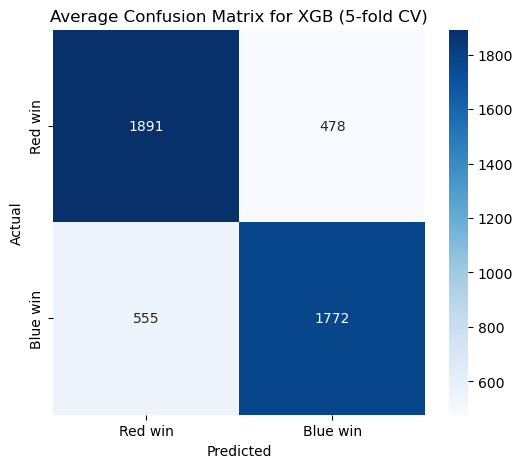

In [255]:
# Fit on Random Forest with k-fold CV
# Initialize hyperparameters and models
kf = KFold(n_splits=k, shuffle=True, random_state=24)
xgb_model = xgb.XGBClassifier(**best_hyperparams, enable_categorical=True)

# Initialize variables to store results
accuracies = []
precisions = []
recalls = []
f1s = []
confusion_matrices = []

# Loop through each fold
for train_index, test_index in kf.split(X):  # Assuming X is the feature matrix
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    xgb_model.fit(X_train, y_train,)

    # Predict the labels
    y_pred = xgb_model.predict(X_test)

    # Calculate metrics for this fold and append it to metric list
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    # Compute confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

# Calculate average accuracy across all folds
print(f"Average Accuracy across {k}-folds: {np.mean(accuracies):.4f}")

# Store all average metrics in final table
results['Model'].append("XGB")
results['Accuracy'].append(np.mean(accuracies))
results['Accuracy SD'].append(np.std(accuracies))
results['Precision'].append(np.mean(precisions))
results['Precision SD'].append(np.std(precisions))
results['Recall'].append(np.mean(recalls))
results['Recall SD'].append(np.std(recalls))
results['F1-Score'].append(np.mean(f1s))
results['F1-Score SD'].append(np.std(f1s))

# Calculate the average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0).astype(int)

# Plot acerage Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Red win', 'Blue win'], yticklabels=['Red win', 'Blue win'])
plt.title(f"Average Confusion Matrix for XGB ({k}-fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [256]:
# Model comparison results
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Accuracy SD,Precision,Precision SD,Recall,Recall SD,F1-Score,F1-Score SD
0,Logistic Regression,0.784158,0.004038,0.783160,0.007541,0.780529,0.003401,0.781826,0.004621
1,LDA,0.784073,0.004076,0.785103,0.007662,0.776931,0.005616,0.780966,0.004693
2,Random Forest,0.776581,0.002854,0.782572,0.009196,0.760548,0.007159,0.771334,0.003813
3,XGB,0.779816,0.007999,0.787437,0.013525,0.761364,0.013065,0.774055,0.008931
